# MODELO DE RIESGO CREDITICIO - PRODUCCIÓN

## Objetivo
Este notebook crea un modelo de predicción de riesgo crediticio optimizado y listo para producción.

**Características:**
- Pipeline de preprocesamiento reproducible
- Modelo serializable para aplicación web
- Métricas enfocadas en el negocio bancario
- Código limpio y documentado

**Variable Objetivo:** `loan_status` (0 = No Default, 1 = Default)

**Métricas Prioritarias para Créditos:**
- **Precision**: Minimizar falsos positivos (no rechazar buenos clientes)
- **Recall**: Detectar clientes de alto riesgo
- **F1-Score**: Balance entre ambas

## 1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Serialización
import joblib
import pickle

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Cargar y Explorar Datos

In [2]:
# Cargar datos
df = pd.read_csv("./dataset/credit_risk_dataset.csv")

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nColumnas:")
for col in df.columns:
    print(f"   - {col}: {df[col].dtype}")

Dimensiones del dataset: (32581, 12)

Columnas:
   - person_age: int64
   - person_income: int64
   - person_home_ownership: object
   - person_emp_length: float64
   - loan_intent: object
   - loan_grade: object
   - loan_amnt: int64
   - loan_int_rate: float64
   - loan_status: int64
   - loan_percent_income: float64
   - cb_person_default_on_file: object
   - cb_person_cred_hist_length: int64


In [3]:
# Vista previa de datos
df.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


In [4]:
# Estadísticas descriptivas
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Distribución de loan_status:
loan_status
0    25473
1     7108
Name: count, dtype: int64

Porcentaje de defaults: 21.82%


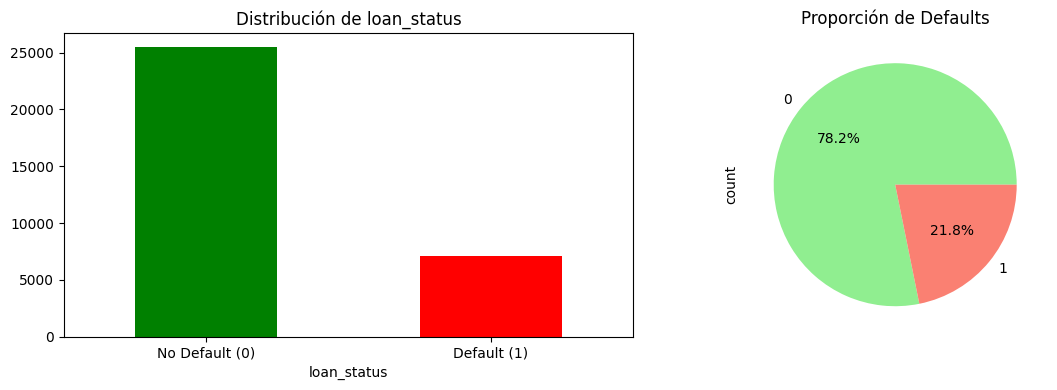

In [5]:
# Distribución de la variable objetivo
print("Distribución de loan_status:")
print(df['loan_status'].value_counts())
print(f"\nPorcentaje de defaults: {df['loan_status'].mean()*100:.2f}%")

# Visualización
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
df['loan_status'].value_counts().plot(kind='bar', ax=ax[0], color=['green', 'red'])
ax[0].set_title('Distribución de loan_status')
ax[0].set_xticklabels(['No Default (0)', 'Default (1)'], rotation=0)

# Gráfico de pastel
df['loan_status'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                       colors=['lightgreen', 'salmon'])
ax[1].set_title('Proporción de Defaults')

plt.tight_layout()
plt.show()

## 3. Limpieza de Datos

In [6]:
# Verificar valores nulos
print("🔍 Valores nulos por columna:")
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

print(f"\nTotal de filas con valores nulos: {df.isnull().any(axis=1).sum()}")

🔍 Valores nulos por columna:
person_emp_length     895
loan_int_rate        3116
dtype: int64

Total de filas con valores nulos: 3943


In [7]:
# Eliminar filas con valores nulos
df_clean = df.dropna().copy()
print(f"Filas después de eliminar nulos: {len(df_clean)} (eliminadas: {len(df) - len(df_clean)})")

Filas después de eliminar nulos: 28638 (eliminadas: 3943)


In [8]:
# Verificar y eliminar outliers
print("Análisis de outliers:")
print(f"   - person_age max: {df_clean['person_age'].max()} (esperado: <100)")
print(f"   - person_emp_length max: {df_clean['person_emp_length'].max()} (esperado: <50)")

# Filtrar outliers
df_clean = df_clean[df_clean['person_age'] <= 80]
df_clean = df_clean[df_clean['person_emp_length'] <= 60]

print(f"\nFilas después de eliminar outliers: {len(df_clean)}")

Análisis de outliers:
   - person_age max: 144 (esperado: <100)
   - person_emp_length max: 123.0 (esperado: <50)

Filas después de eliminar outliers: 28631


## 4. Ingeniería de Características

In [9]:
# Crear características adicionales útiles para el modelo
df_clean['loan_to_income_ratio'] = df_clean['loan_amnt'] / df_clean['person_income']
df_clean['income_per_year_employed'] = df_clean['person_income'] / (df_clean['person_emp_length'] + 1)

print("Características creadas:")
print("   - loan_to_income_ratio: Proporción préstamo/ingreso")
print("   - income_per_year_employed: Ingreso por año de empleo")

Características creadas:
   - loan_to_income_ratio: Proporción préstamo/ingreso
   - income_per_year_employed: Ingreso por año de empleo


In [10]:
# Definir características categóricas y numéricas
CATEGORICAL_FEATURES = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

NUMERICAL_FEATURES = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'loan_to_income_ratio',
    'income_per_year_employed'
]

TARGET = 'loan_status'

print(f"Características categóricas: {len(CATEGORICAL_FEATURES)}")
print(f"Características numéricas: {len(NUMERICAL_FEATURES)}")

Características categóricas: 4
Características numéricas: 9


In [11]:
# Verificar valores únicos de variables categóricas
print("Valores únicos por categoría:")
for col in CATEGORICAL_FEATURES:
    print(f"\n{col}:")
    print(df_clean[col].value_counts())

Valores únicos por categoría:

person_home_ownership:
person_home_ownership
RENT        14548
MORTGAGE    11797
OWN          2192
OTHER          94
Name: count, dtype: int64

loan_intent:
loan_intent
EDUCATION            5702
MEDICAL              5293
VENTURE              4999
PERSONAL             4874
DEBTCONSOLIDATION    4565
HOMEIMPROVEMENT      3198
Name: count, dtype: int64

loan_grade:
loan_grade
A    9400
B    9149
C    5697
D    3247
E     870
F     209
G      59
Name: count, dtype: int64

cb_person_default_on_file:
cb_person_default_on_file
N    23529
Y     5102
Name: count, dtype: int64


## 5. Preparar Datos para Modelado

In [12]:
# Separar features y target
X = df_clean[CATEGORICAL_FEATURES + NUMERICAL_FEATURES]
y = df_clean[TARGET]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (28631, 13)
y shape: (28631,)


In [13]:
# División train/test estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Mantener proporción de clases
)

print(f"📊 Train set: {X_train.shape[0]} muestras")
print(f"📊 Test set: {X_test.shape[0]} muestras")
print(f"\n✅ Proporción de defaults en train: {y_train.mean()*100:.2f}%")
print(f"✅ Proporción de defaults en test: {y_test.mean()*100:.2f}%")

📊 Train set: 22904 muestras
📊 Test set: 5727 muestras

✅ Proporción de defaults en train: 21.66%
✅ Proporción de defaults en test: 21.67%


## 6. Crear Pipeline de Preprocesamiento

In [14]:
# Crear transformadores
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_transformer = StandardScaler()

# Crear preprocessor con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='drop'
)

print("Pipeline de preprocesamiento creado")

Pipeline de preprocesamiento creado


In [15]:
# Ajustar y transformar datos de entrenamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")

X_train_processed shape: (22904, 28)
X_test_processed shape: (5727, 28)


## 7. Entrenamiento y Evaluación de Modelos

In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evalúa un modelo y retorna métricas detalladas"""
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métricas
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }
    
    return model, metrics, y_pred, y_pred_proba

In [17]:
# Definir modelos a evaluar
models = {
    'LightGBM': LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        random_state=42,
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=7,
        random_state=42,
        verbose=0
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=7,
        weights='distance'
    )
}

print(f"Modelos a evaluar: {list(models.keys())}")

Modelos a evaluar: ['LightGBM', 'CatBoost', 'RandomForest', 'KNN']


In [18]:
# Evaluar todos los modelos
results = []
trained_models = {}

for name, model in models.items():
    print(f"\Entrenando {name}...")
    trained_model, metrics, y_pred, y_pred_proba = evaluate_model(
        model, X_train_processed, X_test_processed, y_train, y_test, name
    )
    trained_models[name] = trained_model
    results.append(metrics)
    
    print(f"   Accuracy: {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall: {metrics['recall']:.4f}")
    print(f"   F1-Score: {metrics['f1']:.4f}")
    print(f"   ROC-AUC: {metrics['roc_auc']:.4f}")

# Crear DataFrame con resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('f1', ascending=False)
print("\n" + "="*60)
print("RESUMEN DE RESULTADOS")
print("="*60)
print(results_df.to_string(index=False))

\Entrenando LightGBM...
   Accuracy: 0.9391
   Precision: 0.9705
   Recall: 0.7413
   F1-Score: 0.8406
   ROC-AUC: 0.9483
\Entrenando CatBoost...
   Accuracy: 0.9410
   Precision: 0.9728
   Recall: 0.7486
   F1-Score: 0.8461
   ROC-AUC: 0.9481
\Entrenando RandomForest...
   Accuracy: 0.9345
   Precision: 0.9779
   Recall: 0.7139
   F1-Score: 0.8253
   ROC-AUC: 0.9284
\Entrenando KNN...
   Accuracy: 0.8977
   Precision: 0.8548
   Recall: 0.6358
   F1-Score: 0.7292
   ROC-AUC: 0.8799

RESUMEN DE RESULTADOS
       model  accuracy  precision   recall       f1  roc_auc
    CatBoost  0.940981   0.972775 0.748590 0.846084 0.948133
    LightGBM  0.939061   0.970464 0.741338 0.840566 0.948299
RandomForest  0.934521   0.977925 0.713940 0.825338 0.928436
         KNN  0.897678   0.854821 0.635778 0.729205 0.879907


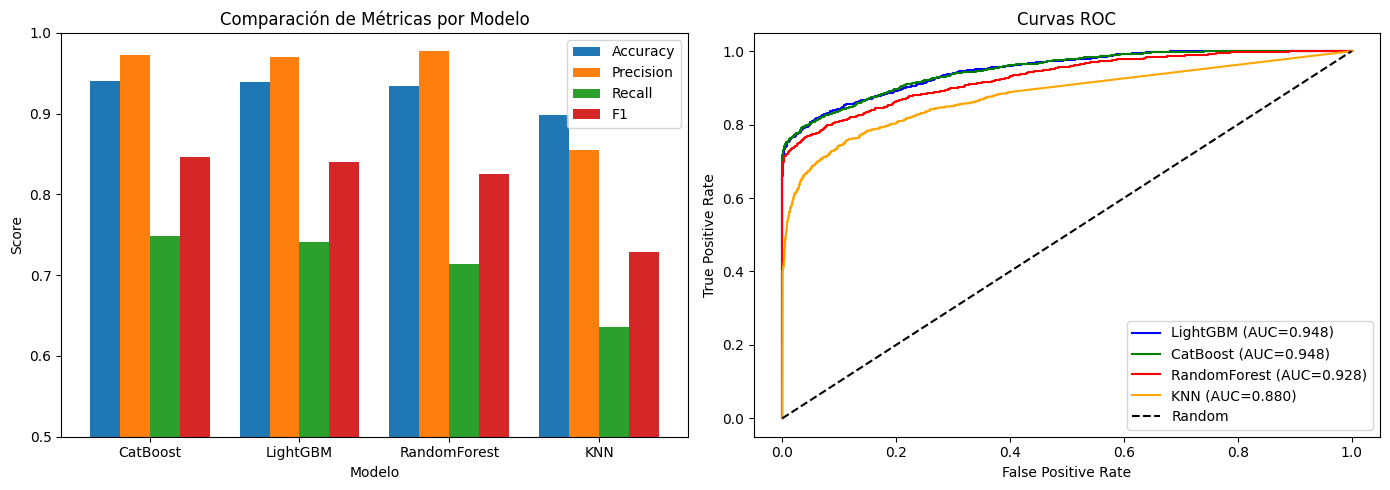

In [19]:
# Visualizar comparación de modelos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras comparativo
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric.capitalize())

axes[0].set_xlabel('Modelo')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparación de Métricas por Modelo')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(results_df['model'])
axes[0].legend()
axes[0].set_ylim([0.5, 1.0])

# ROC-AUC comparativo
colors = ['blue', 'green', 'red', 'orange']
for idx, (name, model) in enumerate(trained_models.items()):
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, color=colors[idx], label=f'{name} (AUC={auc:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Curvas ROC')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Modelo Ensemble (Votación)

In [20]:
# Crear ensemble con los mejores modelos
ensemble = VotingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=7, 
                                num_leaves=31, random_state=42, verbose=-1)),
        # ('catboost', CatBoostClassifier(iterations=200, learning_rate=0.1, depth=7, 
        #                                  random_state=42, verbose=0)),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, 
                                       random_state=42, n_jobs=-1))
    ],
    voting='soft'  # Promedio de probabilidades
)

# Entrenar y evaluar ensemble
print("Entrenando modelo Ensemble...")
ensemble_model, ensemble_metrics, y_pred_ensemble, y_pred_proba_ensemble = evaluate_model(
    ensemble, X_train_processed, X_test_processed, y_train, y_test, 'Ensemble'
)

print(f"\nResultados del Ensemble:")
print(f"   Accuracy: {ensemble_metrics['accuracy']:.4f}")
print(f"   Precision: {ensemble_metrics['precision']:.4f}")
print(f"   Recall: {ensemble_metrics['recall']:.4f}")
print(f"   F1-Score: {ensemble_metrics['f1']:.4f}")
print(f"   ROC-AUC: {ensemble_metrics['roc_auc']:.4f}")

Entrenando modelo Ensemble...

Resultados del Ensemble:
   Accuracy: 0.9389
   Precision: 0.9795
   Recall: 0.7333
   F1-Score: 0.8387
   ROC-AUC: 0.9428


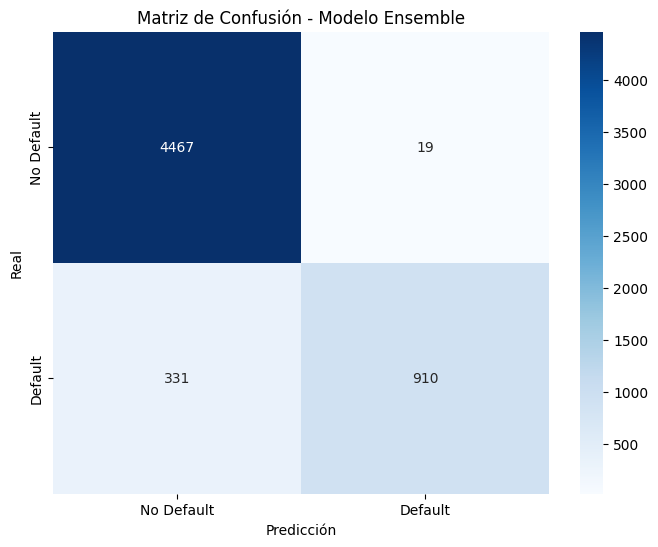

\Reporte de Clasificación:
              precision    recall  f1-score   support

  No Default       0.93      1.00      0.96      4486
     Default       0.98      0.73      0.84      1241

    accuracy                           0.94      5727
   macro avg       0.96      0.86      0.90      5727
weighted avg       0.94      0.94      0.94      5727



In [21]:
# Matriz de confusión del mejor modelo
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
ax.set_title('Matriz de Confusión - Modelo Ensemble')
plt.show()

# Reporte de clasificación
print("\Reporte de Clasificación:")
print(classification_report(y_test, y_pred_ensemble, 
                           target_names=['No Default', 'Default']))

## 9. Seleccionar y Preparar Modelo Final

In [22]:
# Para aplicaciones de crédito, preferimos alta precisión para no rechazar buenos clientes

# Usaremos LightGBM como modelo final por su balance y eficiencia
final_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

# Reentrenar con todos los datos preprocesados
final_model.fit(X_train_processed, y_train)

# Validación final
y_pred_final = final_model.predict(X_test_processed)
y_pred_proba_final = final_model.predict_proba(X_test_processed)[:, 1]

print("Modelo Final entrenado: LightGBM")
print(f"\nMétricas finales:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_final):.4f}")

Modelo Final entrenado: LightGBM

Métricas finales:
   Accuracy: 0.9396
   Precision: 0.9637
   Recall: 0.7494
   F1-Score: 0.8432
   ROC-AUC: 0.9519


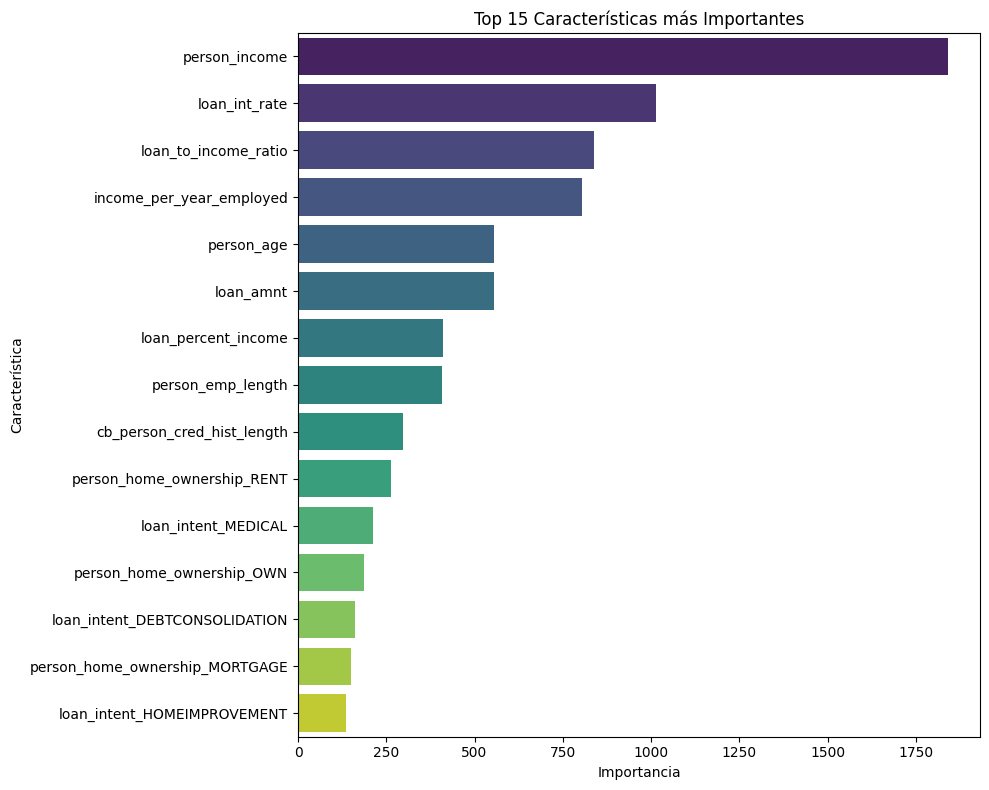

In [23]:
# Feature Importance del modelo final
feature_names = NUMERICAL_FEATURES + list(preprocessor.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_FEATURES))

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizar top 15 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = importance_df.head(15)
sns.barplot(data=top_features, y='feature', x='importance', ax=ax, palette='viridis')
ax.set_title('Top 15 Características más Importantes')
ax.set_xlabel('Importancia')
ax.set_ylabel('Característica')
plt.tight_layout()
plt.show()

## 10. Guardar Modelo y Artefactos para Producción

In [24]:
import os

# Crear directorio para modelos
MODEL_DIR = './models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Guardar modelo
joblib.dump(final_model, f'{MODEL_DIR}/credit_risk_model.joblib')
print(f"Modelo guardado: {MODEL_DIR}/credit_risk_model.joblib")

# Guardar preprocessor
joblib.dump(preprocessor, f'{MODEL_DIR}/preprocessor.joblib')
print(f"Preprocessor guardado: {MODEL_DIR}/preprocessor.joblib")
# Guardar configuración de características
feature_config = {
    'categorical_features': CATEGORICAL_FEATURES,
    'numerical_features': NUMERICAL_FEATURES,
    'target': TARGET
}
joblib.dump(feature_config, f'{MODEL_DIR}/feature_config.joblib')
print(f"Configuración guardada: {MODEL_DIR}/feature_config.joblib")

Modelo guardado: ./models/credit_risk_model.joblib
Preprocessor guardado: ./models/preprocessor.joblib
Configuración guardada: ./models/feature_config.joblib


In [25]:
# Crear pipeline completo para producción
production_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

# Guardar pipeline completo
joblib.dump(production_pipeline, f'{MODEL_DIR}/credit_risk_pipeline.joblib')
print(f"Pipeline completo guardado: {MODEL_DIR}/credit_risk_pipeline.joblib")

Pipeline completo guardado: ./models/credit_risk_pipeline.joblib


## 11. Crear Función de Predicción para Producción

In [26]:
def predict_credit_risk(input_data: dict):
    """
    Función para predecir riesgo crediticio.
    
    Parámetros:
    -----------
    input_data : dict
        Diccionario con las características del solicitante:
        - person_age: Edad del solicitante
        - person_income: Ingreso anual
        - person_home_ownership: Tipo de vivienda (RENT, OWN, MORTGAGE, OTHER)
        - person_emp_length: Años de empleo
        - loan_intent: Propósito del préstamo (PERSONAL, EDUCATION, MEDICAL, VENTURE, HOMEIMPROVEMENT, DEBTCONSOLIDATION)
        - loan_grade: Grado del préstamo (A, B, C, D, E, F, G)
        - loan_amnt: Monto del préstamo
        - loan_int_rate: Tasa de interés
        - loan_percent_income: Porcentaje del préstamo vs ingreso
        - cb_person_default_on_file: Historial de default (Y, N)
        - cb_person_cred_hist_length: Longitud del historial crediticio
        
    Retorna:
    --------
    dict: Predicción y probabilidad de riesgo
    """
    # Cargar pipeline
    pipeline = joblib.load(f'{MODEL_DIR}/credit_risk_pipeline.joblib')
    feature_config = joblib.load(f'{MODEL_DIR}/feature_config.joblib')
    
    # Crear características adicionales
    input_data['loan_to_income_ratio'] = input_data['loan_amnt'] / input_data['person_income']
    input_data['income_per_year_employed'] = input_data['person_income'] / (input_data['person_emp_length'] + 1)
    
    # Crear DataFrame
    df_input = pd.DataFrame([input_data])
    
    # Ordenar columnas
    df_input = df_input[feature_config['categorical_features'] + feature_config['numerical_features']]
    
    # Predecir
    prediction = pipeline.predict(df_input)[0]
    probability = pipeline.predict_proba(df_input)[0]
    
    # Interpretar resultado
    risk_level = 'ALTO' if prediction == 1 else 'BAJO'
    
    return {
        'prediction': int(prediction),
        'risk_level': risk_level,
        'probability_no_default': float(probability[0]),
        'probability_default': float(probability[1]),
        'recommendation': 'RECHAZAR' if probability[1] > 0.5 else 'APROBAR',
        'confidence': float(max(probability))
    }

In [27]:
# Ejemplo de uso de la función de predicción
ejemplo_cliente = {
    'person_age': 28,
    'person_income': 30000,
    'person_home_ownership': 'RENT',
    'person_emp_length': 5,
    'loan_intent': 'PERSONAL',
    'loan_grade': 'B',
    'loan_amnt': 10000,
    'loan_int_rate': 11.5,
    'loan_percent_income': 0.17,
    'cb_person_default_on_file': 'N',
    'cb_person_cred_hist_length': 4
}

resultado = predict_credit_risk(ejemplo_cliente)

print("RESULTADO DE EVALUACIÓN CREDITICIA")
print("="*50)
print(f"Predicción: {resultado['risk_level']}")
print(f"Probabilidad de Default: {resultado['probability_default']*100:.2f}%")
print(f"Probabilidad de No Default: {resultado['probability_no_default']*100:.2f}%")
print(f"Recomendación: {resultado['recommendation']}")
print(f"Confianza: {resultado['confidence']*100:.2f}%")

RESULTADO DE EVALUACIÓN CREDITICIA
Predicción: ALTO
Probabilidad de Default: 94.12%
Probabilidad de No Default: 5.88%
Recomendación: RECHAZAR
Confianza: 94.12%


## 12. Guardar Script de Predicción para API Web

In [28]:
# Crear archivo Python con la función de predicción para usar en una API
prediction_script = '''
"""Módulo de predicción de riesgo crediticio para producción"""

import pandas as pd
import joblib
from pathlib import Path

# Ruta al directorio de modelos
MODEL_DIR = Path(__file__).parent / "models"

# Cargar artefactos una sola vez
_pipeline = None
_feature_config = None

def load_model():
    """Carga el modelo y configuración en memoria"""
    global _pipeline, _feature_config
    if _pipeline is None:
        _pipeline = joblib.load(MODEL_DIR / "credit_risk_pipeline.joblib")
        _feature_config = joblib.load(MODEL_DIR / "feature_config.joblib")
    return _pipeline, _feature_config


def predict_credit_risk(input_data: dict) -> dict:
    """
    Predice el riesgo crediticio de un solicitante.
    
    Parámetros:
    -----------
    input_data : dict
        Diccionario con las características del solicitante:
        - person_age: int - Edad del solicitante
        - person_income: float - Ingreso anual
        - person_home_ownership: str - Tipo de vivienda (RENT, OWN, MORTGAGE, OTHER)
        - person_emp_length: float - Años de empleo
        - loan_intent: str - Propósito (PERSONAL, EDUCATION, MEDICAL, VENTURE, HOMEIMPROVEMENT, DEBTCONSOLIDATION)
        - loan_grade: str - Grado del préstamo (A-G)
        - loan_amnt: float - Monto del préstamo
        - loan_int_rate: float - Tasa de interés
        - loan_percent_income: float - Porcentaje préstamo/ingreso
        - cb_person_default_on_file: str - Historial de default (Y, N)
        - cb_person_cred_hist_length: int - Años de historial crediticio
        
    Retorna:
    --------
    dict: Resultado de la predicción con:
        - prediction: 0 o 1
        - risk_level: ALTO o BAJO
        - probability_default: float
        - probability_no_default: float
        - recommendation: APROBAR o RECHAZAR
        - confidence: float
    """
    pipeline, feature_config = load_model()
    
    # Calcular características derivadas
    input_data = input_data.copy()
    input_data["loan_to_income_ratio"] = input_data["loan_amnt"] / input_data["person_income"]
    input_data["income_per_year_employed"] = input_data["person_income"] / (input_data["person_emp_length"] + 1)
    
    # Crear DataFrame con orden correcto de columnas
    df_input = pd.DataFrame([input_data])
    df_input = df_input[feature_config["categorical_features"] + feature_config["numerical_features"]]
    
    # Realizar predicción
    prediction = pipeline.predict(df_input)[0]
    probability = pipeline.predict_proba(df_input)[0]
    
    return {
        "prediction": int(prediction),
        "risk_level": "ALTO" if prediction == 1 else "BAJO",
        "probability_no_default": round(float(probability[0]), 4),
        "probability_default": round(float(probability[1]), 4),
        "recommendation": "RECHAZAR" if probability[1] > 0.5 else "APROBAR",
        "confidence": round(float(max(probability)), 4)
    }


# Valores válidos para campos categóricos
VALID_VALUES = {
    "person_home_ownership": ["RENT", "OWN", "MORTGAGE", "OTHER"],
    "loan_intent": ["PERSONAL", "EDUCATION", "MEDICAL", "VENTURE", "HOMEIMPROVEMENT", "DEBTCONSOLIDATION"],
    "loan_grade": ["A", "B", "C", "D", "E", "F", "G"],
    "cb_person_default_on_file": ["Y", "N"]
}


def validate_input(input_data: dict) -> tuple:
    """
    Valida los datos de entrada.
    
    Retorna:
    --------
    tuple: (is_valid: bool, errors: list)
    """
    errors = []
    
    required_fields = [
        "person_age", "person_income", "person_home_ownership", "person_emp_length",
        "loan_intent", "loan_grade", "loan_amnt", "loan_int_rate",
        "loan_percent_income", "cb_person_default_on_file", "cb_person_cred_hist_length"
    ]
    
    # Verificar campos requeridos
    for field in required_fields:
        if field not in input_data:
            errors.append(f"Campo requerido faltante: {field}")
    
    if errors:
        return False, errors
    
    # Validar rangos numéricos
    if not (18 <= input_data["person_age"] <= 100):
        errors.append("person_age debe estar entre 18 y 100")
    
    if input_data["person_income"] <= 0:
        errors.append("person_income debe ser mayor a 0")
        
    if input_data["loan_amnt"] <= 0:
        errors.append("loan_amnt debe ser mayor a 0")
    
    # Validar campos categóricos
    for field, valid_values in VALID_VALUES.items():
        if input_data.get(field) not in valid_values:
            errors.append(f"{field} debe ser uno de: {valid_values}")
    
    return len(errors) == 0, errors


if __name__ == "__main__":
    # Ejemplo de uso
    test_data = {
        "person_age": 28,
        "person_income": 60000,
        "person_home_ownership": "RENT",
        "person_emp_length": 5,
        "loan_intent": "PERSONAL",
        "loan_grade": "B",
        "loan_amnt": 10000,
        "loan_int_rate": 11.5,
        "loan_percent_income": 0.17,
        "cb_person_default_on_file": "N",
        "cb_person_cred_hist_length": 4
    }
    
    is_valid, errors = validate_input(test_data)
    if is_valid:
        result = predict_credit_risk(test_data)
        print("Resultado:", result)
    else:
        print("Errores de validación:", errors)
'''

# Guardar el script
with open('credit_risk_predictor.py', 'w') as f:
    f.write(prediction_script)

print("✅ Script de predicción guardado: credit_risk_predictor.py")

✅ Script de predicción guardado: credit_risk_predictor.py


## 13. Resumen Final

In [29]:
print("="*70)
print("📋 RESUMEN DEL MODELO DE RIESGO CREDITICIO")
print("="*70)
print(f"""
MODELO FINAL: LightGBM Classifier

MÉTRICAS DE RENDIMIENTO:
   - Accuracy:  {accuracy_score(y_test, y_pred_final):.4f}
   - Precision: {precision_score(y_test, y_pred_final):.4f}
   - Recall:    {recall_score(y_test, y_pred_final):.4f}
   - F1-Score:  {f1_score(y_test, y_pred_final):.4f}
   - ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_final):.4f}

ARCHIVOS GUARDADOS:
   - models/credit_risk_model.joblib      (Modelo entrenado)
   - models/preprocessor.joblib           (Preprocesador)
   - models/feature_config.joblib         (Configuración)
   - models/credit_risk_pipeline.joblib   (Pipeline completo)
   - credit_risk_predictor.py             (Script para API)

USO EN PRODUCCIÓN:
   from credit_risk_predictor import predict_credit_risk, validate_input
   
   # Validar datos
   is_valid, errors = validate_input(client_data)
   
   # Predecir
   if is_valid:
       result = predict_credit_risk(client_data)

VARIABLES DE ENTRADA REQUERIDAS:
   - person_age: Edad del solicitante (18-100)
   - person_income: Ingreso anual
   - person_home_ownership: RENT, OWN, MORTGAGE, OTHER
   - person_emp_length: Años de empleo
   - loan_intent: PERSONAL, EDUCATION, MEDICAL, VENTURE, HOMEIMPROVEMENT, DEBTCONSOLIDATION
   - loan_grade: A, B, C, D, E, F, G
   - loan_amnt: Monto del préstamo
   - loan_int_rate: Tasa de interés
   - loan_percent_income: Proporción préstamo/ingreso
   - cb_person_default_on_file: Y, N
   - cb_person_cred_hist_length: Años de historial crediticio
""")
print("="*70)

📋 RESUMEN DEL MODELO DE RIESGO CREDITICIO

MODELO FINAL: LightGBM Classifier

MÉTRICAS DE RENDIMIENTO:
   - Accuracy:  0.9396
   - Precision: 0.9637
   - Recall:    0.7494
   - F1-Score:  0.8432
   - ROC-AUC:   0.9519

ARCHIVOS GUARDADOS:
   - models/credit_risk_model.joblib      (Modelo entrenado)
   - models/preprocessor.joblib           (Preprocesador)
   - models/feature_config.joblib         (Configuración)
   - models/credit_risk_pipeline.joblib   (Pipeline completo)
   - credit_risk_predictor.py             (Script para API)

USO EN PRODUCCIÓN:
   from credit_risk_predictor import predict_credit_risk, validate_input

   # Validar datos
   is_valid, errors = validate_input(client_data)

   # Predecir
   if is_valid:
       result = predict_credit_risk(client_data)

VARIABLES DE ENTRADA REQUERIDAS:
   - person_age: Edad del solicitante (18-100)
   - person_income: Ingreso anual
   - person_home_ownership: RENT, OWN, MORTGAGE, OTHER
   - person_emp_length: Años de empleo
   - loan_

# ============================================================
# MEJORAS AVANZADAS DEL MODELO
# ============================================================

## 14. Optimización de Hiperparámetros con Optuna

Entrenaremos el modelo por más tiempo usando optimización bayesiana para encontrar los mejores hiperparámetros.

In [30]:
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb

def objective(trial):
    """Función objetivo para optimización con Optuna"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbose': -1
    }
    
    model = LGBMClassifier(**params)
    
    # Validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='f1')
    
    return scores.mean()

# Ejecutar optimización (esto tomará varios minutos)
print("Iniciando optimización de hiperparámetros...")
print("   Esto tomará aproximadamente 3-5 minutos para encontrar los mejores parámetros.\n")

optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\Optimización completada!")
print(f"   Mejor F1-Score: {study.best_value:.4f}")
print(f"   Mejores parámetros: {study.best_params}")

Iniciando optimización de hiperparámetros...
   Esto tomará aproximadamente 3-5 minutos para encontrar los mejores parámetros.



  0%|          | 0/50 [00:00<?, ?it/s]

\Optimización completada!
   Mejor F1-Score: 0.8361
   Mejores parámetros: {'n_estimators': 894, 'learning_rate': 0.08615875277360491, 'max_depth': 9, 'num_leaves': 68, 'min_child_samples': 14, 'subsample': 0.83652788774146, 'colsample_bytree': 0.7591547737301964, 'reg_alpha': 0.17145060009596438, 'reg_lambda': 3.242714271757108e-06}


In [31]:
# Entrenar modelo optimizado con los mejores parámetros
best_params = study.best_params
best_params['random_state'] = 42
best_params['verbose'] = -1

optimized_model = LGBMClassifier(**best_params)

# Entrenar con validación temprana para evitar overfitting
print("Entrenando modelo optimizado...")
optimized_model.fit(
    X_train_processed, 
    y_train,
    eval_set=[(X_test_processed, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Evaluar modelo optimizado
y_pred_optimized = optimized_model.predict(X_test_processed)
y_pred_proba_optimized = optimized_model.predict_proba(X_test_processed)[:, 1]

print(f"\nMétricas del Modelo Optimizado:")
print(f"   Accuracy:  {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_optimized):.4f}")
print(f"   Recall:    {recall_score(y_test, y_pred_optimized):.4f}")
print(f"   F1-Score:  {f1_score(y_test, y_pred_optimized):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")

# Comparar con modelo anterior
print(f"\nMejora respecto al modelo base:")
f1_base = f1_score(y_test, y_pred_final)
f1_opt = f1_score(y_test, y_pred_optimized)
print(f"   F1-Score: {f1_base:.4f} → {f1_opt:.4f} ({(f1_opt-f1_base)*100:+.2f}%)")

Entrenando modelo optimizado...

Métricas del Modelo Optimizado:
   Accuracy:  0.9399
   Precision: 0.9553
   Recall:    0.7583
   F1-Score:  0.8455
   ROC-AUC:   0.9554

Mejora respecto al modelo base:
   F1-Score: 0.8432 → 0.8455 (+0.23%)


In [32]:
# Usar el modelo optimizado como modelo final
final_model = optimized_model
y_pred_final = y_pred_optimized
y_pred_proba_final = y_pred_proba_optimized

print("✅ Modelo optimizado establecido como modelo final")

✅ Modelo optimizado establecido como modelo final


## 15. Sistema de Score Crediticio (300-850)

Crearemos un score crediticio personalizado similar al FICO Score que considera múltiples factores.

In [33]:
def calculate_credit_score(probability_no_default, input_data):
    """
    Calcula un score crediticio de 300 a 850 (similar a FICO)
    basado en la probabilidad de no default y factores adicionales.
    
    Score Ranges:
    - 300-579: Muy Pobre
    - 580-669: Regular
    - 670-739: Bueno
    - 740-799: Muy Bueno
    - 800-850: Excelente
    """
    # Base score desde la probabilidad (60% del peso)
    base_score = 300 + (probability_no_default * 550 * 0.6)
    
    # Ajustes por factores adicionales (40% del peso)
    adjustments = 0
    
    # Factor 1: Historial crediticio (hasta +80 puntos)
    cred_hist = input_data.get('cb_person_cred_hist_length', 0)
    if cred_hist >= 10:
        adjustments += 80
    elif cred_hist >= 5:
        adjustments += 50
    elif cred_hist >= 2:
        adjustments += 25
    
    # Factor 2: Sin default previo (hasta +60 puntos)
    if input_data.get('cb_person_default_on_file', 'Y') == 'N':
        adjustments += 60
    
    # Factor 3: Estabilidad laboral (hasta +50 puntos)
    emp_length = input_data.get('person_emp_length', 0)
    if emp_length >= 10:
        adjustments += 50
    elif emp_length >= 5:
        adjustments += 35
    elif emp_length >= 2:
        adjustments += 15
    
    # Factor 4: Ratio préstamo/ingreso (hasta +30 puntos)
    loan_percent = input_data.get('loan_percent_income', 1)
    if loan_percent <= 0.1:
        adjustments += 30
    elif loan_percent <= 0.2:
        adjustments += 20
    elif loan_percent <= 0.3:
        adjustments += 10
    
    # Factor 5: Grado del préstamo (hasta +30 puntos)
    grade_scores = {'A': 30, 'B': 25, 'C': 15, 'D': 5, 'E': 0, 'F': -10, 'G': -20}
    adjustments += grade_scores.get(input_data.get('loan_grade', 'G'), 0)
    
    # Calcular score final
    final_score = base_score + adjustments
    
    # Limitar al rango 300-850
    final_score = max(300, min(850, final_score))
    
    return round(final_score)


def get_score_category(score):
    """Retorna la categoría del score crediticio"""
    if score >= 800:
        return "Excelente", "🌟", "#2E7D32"
    elif score >= 740:
        return "Muy Bueno", "✅", "#388E3C"
    elif score >= 670:
        return "Bueno", "👍", "#689F38"
    elif score >= 580:
        return "Regular", "⚠️", "#FFA000"
    else:
        return "Pobre", "❌", "#D32F2F"

print("Sistema de Score Crediticio implementado (rango 300-850)")

Sistema de Score Crediticio implementado (rango 300-850)


## 16. Sistema de Recomendación de Préstamo

Calcularemos el monto máximo recomendado, tasa sugerida y condiciones óptimas para cada cliente.

In [34]:
def calculate_loan_recommendation(input_data, credit_score, probability_default):
    """
    Calcula recomendaciones de préstamo personalizadas.
    
    Retorna:
    - Monto máximo recomendado
    - Tasa de interés sugerida
    - Plazo recomendado
    - Condiciones especiales
    """
    income = input_data['person_income']
    requested_amount = input_data['loan_amnt']
    requested_rate = input_data['loan_int_rate']
    
    # === MONTO MÁXIMO RECOMENDADO ===
    # Basado en DTI (Debt-to-Income) máximo del 40%
    base_max_loan = income * 0.40
    
    # Ajustar según score crediticio
    if credit_score >= 800:
        max_loan_multiplier = 1.5
    elif credit_score >= 740:
        max_loan_multiplier = 1.3
    elif credit_score >= 670:
        max_loan_multiplier = 1.0
    elif credit_score >= 580:
        max_loan_multiplier = 0.7
    else:
        max_loan_multiplier = 0.5
    
    max_recommended_loan = base_max_loan * max_loan_multiplier
    
    # === TASA DE INTERÉS SUGERIDA ===
    base_rate = 6.0  # Tasa base del mercado
    risk_premium = probability_default * 15  # Hasta +15% adicional por riesgo
    
    # Ajuste por score
    if credit_score >= 800:
        score_adjustment = -1.0
    elif credit_score >= 740:
        score_adjustment = 0
    elif credit_score >= 670:
        score_adjustment = 1.5
    elif credit_score >= 580:
        score_adjustment = 3.0
    else:
        score_adjustment = 5.0
    
    suggested_rate = base_rate + risk_premium + score_adjustment
    suggested_rate = max(5.0, min(25.0, suggested_rate))  # Limitar entre 5% y 25%
    
    # === PLAZO RECOMENDADO (en meses) ===
    if credit_score >= 740:
        max_term = 60  # 5 años
    elif credit_score >= 670:
        max_term = 48  # 4 años
    elif credit_score >= 580:
        max_term = 36  # 3 años
    else:
        max_term = 24  # 2 años
    
    # === PAGO MENSUAL ESTIMADO ===
    loan_amount = min(requested_amount, max_recommended_loan)
    monthly_rate = suggested_rate / 100 / 12
    n_payments = max_term
    
    if monthly_rate > 0:
        monthly_payment = loan_amount * (monthly_rate * (1 + monthly_rate)**n_payments) / ((1 + monthly_rate)**n_payments - 1)
    else:
        monthly_payment = loan_amount / n_payments
    
    # === CONDICIONES ESPECIALES ===
    conditions = []
    
    if requested_amount > max_recommended_loan:
        conditions.append(f"Monto solicitado (${requested_amount:,.0f}) excede el recomendado")
        conditions.append(f"Considere reducir a ${max_recommended_loan:,.0f}")
    
    if requested_rate < suggested_rate - 2:
        conditions.append(f"Tasa solicitada ({requested_rate}%) muy baja para su perfil")
    
    if input_data.get('cb_person_default_on_file') == 'Y':
        conditions.append("Se requiere garantía adicional por historial de default")
    
    if input_data.get('person_emp_length', 0) < 2:
        conditions.append("Se requiere comprobante de ingresos de los últimos 6 meses")
    
    if credit_score >= 740 and probability_default < 0.1:
        conditions.append("Elegible para programa de tasas preferenciales")
        conditions.append("Posible exención de comisión por apertura")
    
    return {
        'max_recommended_loan': round(max_recommended_loan, 2),
        'suggested_rate': round(suggested_rate, 2),
        'max_term_months': max_term,
        'monthly_payment': round(monthly_payment, 2),
        'total_interest': round(monthly_payment * max_term - loan_amount, 2),
        'conditions': conditions,
        'approved_amount': min(requested_amount, max_recommended_loan)
    }

print("Sistema de Recomendación de Préstamo implementado")

Sistema de Recomendación de Préstamo implementado


## 17. Función de Evaluación Completa para Producción

Esta función integra todos los sistemas: predicción de riesgo, score crediticio, y recomendaciones de préstamo.

In [35]:
def evaluate_credit_application(input_data: dict) -> dict:
    """
    Evaluación completa de solicitud de crédito.
    
    Retorna un diccionario completo con:
    - Predicción de riesgo
    - Score crediticio
    - Recomendaciones de préstamo
    - Decisión final
    """
    # Cargar modelos y configuración
    pipeline = joblib.load(f'{MODEL_DIR}/credit_risk_pipeline.joblib')
    feature_config = joblib.load(f'{MODEL_DIR}/feature_config.joblib')
    
    # Preparar datos
    input_copy = input_data.copy()
    input_copy['loan_to_income_ratio'] = input_copy['loan_amnt'] / input_copy['person_income']
    input_copy['income_per_year_employed'] = input_copy['person_income'] / (input_copy['person_emp_length'] + 1)
    
    df_input = pd.DataFrame([input_copy])
    df_input = df_input[feature_config['categorical_features'] + feature_config['numerical_features']]
    
    # === PREDICCIÓN ===
    prediction = pipeline.predict(df_input)[0]
    probability = pipeline.predict_proba(df_input)[0]
    prob_no_default = probability[0]
    prob_default = probability[1]
    
    # === SCORE CREDITICIO ===
    credit_score = calculate_credit_score(prob_no_default, input_data)
    score_category, score_emoji, score_color = get_score_category(credit_score)
    
    # === RECOMENDACIONES DE PRÉSTAMO ===
    loan_recommendation = calculate_loan_recommendation(input_data, credit_score, prob_default)
    
    # === DECISIÓN FINAL ===
    if credit_score >= 670 and prob_default < 0.3:
        decision = "APROBADO"
        decision_color = "green"
    elif credit_score >= 580 and prob_default < 0.5:
        decision = "APROBADO CON CONDICIONES"
        decision_color = "orange"
    else:
        decision = "RECHAZADO"
        decision_color = "red"
    
    # Construir respuesta completa
    result = {
        # Información básica
        'applicant_summary': {
            'age': input_data['person_age'],
            'income': input_data['person_income'],
            'employment_years': input_data['person_emp_length'],
            'home_ownership': input_data['person_home_ownership'],
            'loan_purpose': input_data['loan_intent']
        },
        
        # Predicción de riesgo
        'risk_assessment': {
            'prediction': int(prediction),
            'risk_level': 'ALTO' if prediction == 1 else 'BAJO',
            'probability_default': round(prob_default, 4),
            'probability_no_default': round(prob_no_default, 4),
            'confidence': round(max(probability), 4)
        },
        
        # Score crediticio
        'credit_score': {
            'score': credit_score,
            'category': score_category,
            'emoji': score_emoji,
            'color': score_color,
            'range': '300-850'
        },
        
        # Recomendaciones de préstamo
        'loan_recommendation': loan_recommendation,
        
        # Solicitud original
        'original_request': {
            'amount': input_data['loan_amnt'],
            'rate': input_data['loan_int_rate'],
            'grade': input_data['loan_grade']
        },
        
        # Decisión final
        'final_decision': {
            'decision': decision,
            'color': decision_color
        }
    }
    
    return result

print("Función de Evaluación Completa implementada")

Función de Evaluación Completa implementada


## 18. Demostración del Sistema Completo

Probaremos el sistema con diferentes perfiles de clientes para ver cómo funciona la evaluación integral.

In [36]:
# Probar con diferentes perfiles de cliente

test_clients = [
    {
        'name': 'Cliente Premium (Excelente perfil)',
        'data': {
            'person_age': 45,
            'person_income': 120000,
            'person_home_ownership': 'OWN',
            'person_emp_length': 15,
            'loan_intent': 'HOMEIMPROVEMENT',
            'loan_grade': 'A',
            'loan_amnt': 25000,
            'loan_int_rate': 7.5,
            'loan_percent_income': 0.21,
            'cb_person_default_on_file': 'N',
            'cb_person_cred_hist_length': 12
        }
    },
    {
        'name': 'Cliente Regular (Perfil medio)',
        'data': {
            'person_age': 32,
            'person_income': 55000,
            'person_home_ownership': 'RENT',
            'person_emp_length': 4,
            'loan_intent': 'PERSONAL',
            'loan_grade': 'C',
            'loan_amnt': 15000,
            'loan_int_rate': 13.5,
            'loan_percent_income': 0.27,
            'cb_person_default_on_file': 'N',
            'cb_person_cred_hist_length': 5
        }
    },
    {
        'name': 'Cliente Riesgoso (Perfil bajo)',
        'data': {
            'person_age': 23,
            'person_income': 28000,
            'person_home_ownership': 'RENT',
            'person_emp_length': 1,
            'loan_intent': 'VENTURE',
            'loan_grade': 'E',
            'loan_amnt': 20000,
            'loan_int_rate': 18.5,
            'loan_percent_income': 0.71,
            'cb_person_default_on_file': 'Y',
            'cb_person_cred_hist_length': 2
        }
    }
]

print("="*80)
print("SISTEMA DE EVALUACIÓN CREDITICIA AVANZADO")
print("="*80)

for client in test_clients:
    print(f"\n{'─'*80}")
    print(f"👤 {client['name']}")
    print(f"{'─'*80}")
    
    result = evaluate_credit_application(client['data'])
    
    # Mostrar Score Crediticio
    score = result['credit_score']
    print(f"\nSCORE CREDITICIO: {score['score']} {score['emoji']} ({score['category']})")
    print(f"   Rango: {score['range']}")
    
    # Mostrar Evaluación de Riesgo
    risk = result['risk_assessment']
    print(f"\nEVALUACIÓN DE RIESGO:")
    print(f"   Nivel de Riesgo: {risk['risk_level']}")
    print(f"   Probabilidad de Default: {risk['probability_default']*100:.2f}%")
    print(f"   Confianza: {risk['confidence']*100:.2f}%")
    
    # Mostrar Recomendación de Préstamo
    loan = result['loan_recommendation']
    orig = result['original_request']
    print(f"\nANÁLISIS DE PRÉSTAMO:")
    print(f"   Solicitado: ${orig['amount']:,.0f} al {orig['rate']}%")
    print(f"   Monto Máximo Recomendado: ${loan['max_recommended_loan']:,.0f}")
    print(f"   Tasa Sugerida: {loan['suggested_rate']:.2f}%")
    print(f"   Plazo Máximo: {loan['max_term_months']} meses")
    print(f"   Pago Mensual Estimado: ${loan['monthly_payment']:,.2f}")
    
    if loan['conditions']:
        print(f"\nCONDICIONES:")
        for cond in loan['conditions']:
            print(f"   {cond}")
    
    # Decisión Final
    decision = result['final_decision']
    print(f"\n{'='*40}")
    print(f"DECISIÓN FINAL: {decision['decision']}")
    print(f"{'='*40}")

SISTEMA DE EVALUACIÓN CREDITICIA AVANZADO

────────────────────────────────────────────────────────────────────────────────
👤 Cliente Premium (Excelente perfil)
────────────────────────────────────────────────────────────────────────────────

SCORE CREDITICIO: 850 🌟 (Excelente)
   Rango: 300-850

EVALUACIÓN DE RIESGO:
   Nivel de Riesgo: BAJO
   Probabilidad de Default: 0.08%
   Confianza: 99.92%

ANÁLISIS DE PRÉSTAMO:
   Solicitado: $25,000 al 7.5%
   Monto Máximo Recomendado: $72,000
   Tasa Sugerida: 5.01%
   Plazo Máximo: 60 meses
   Pago Mensual Estimado: $471.91

CONDICIONES:
   Elegible para programa de tasas preferenciales
   Posible exención de comisión por apertura

DECISIÓN FINAL: APROBADO

────────────────────────────────────────────────────────────────────────────────
👤 Cliente Regular (Perfil medio)
────────────────────────────────────────────────────────────────────────────────

SCORE CREDITICIO: 744 ✅ (Muy Bueno)
   Rango: 300-850

EVALUACIÓN DE RIESGO:
   Nivel de Ries

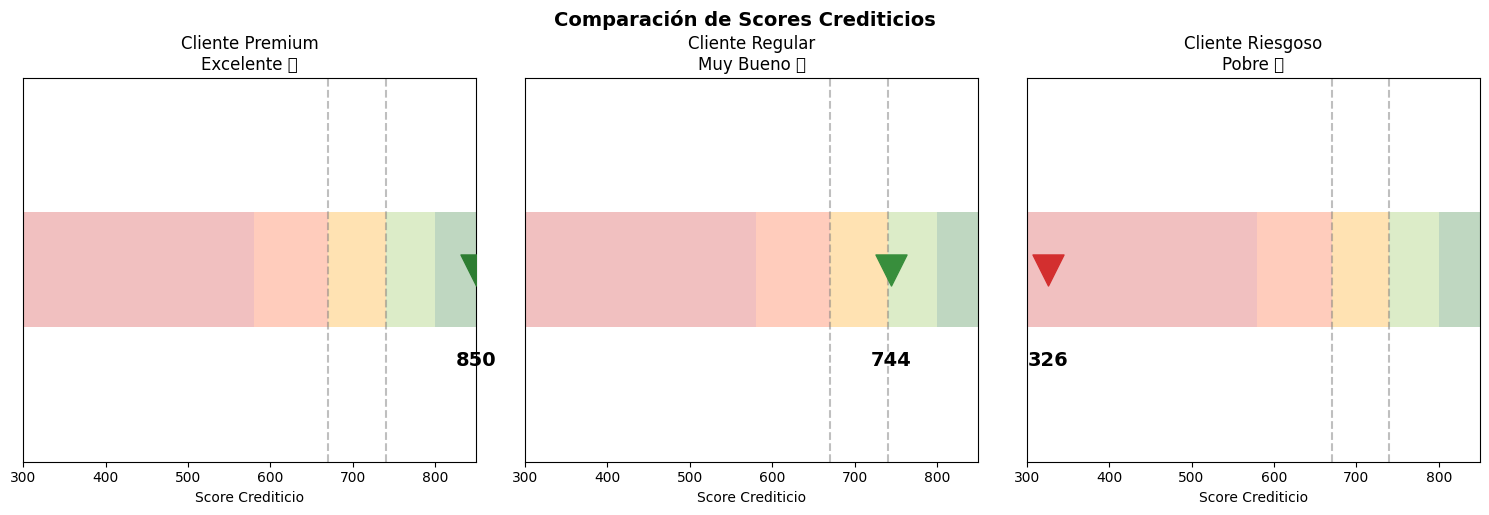

In [37]:
# Visualización comparativa de los perfiles
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, client in enumerate(test_clients):
    result = evaluate_credit_application(client['data'])
    score = result['credit_score']['score']
    
    ax = axes[idx]
    
    # Colores por rango
    colors = ['#D32F2F', '#FF5722', '#FFA000', '#8BC34A', '#2E7D32']
    ranges = [300, 580, 670, 740, 800, 850]
    
    # Barras de fondo
    for i in range(len(ranges)-1):
        ax.barh(0, ranges[i+1]-ranges[i], left=ranges[i], height=0.3, color=colors[i], alpha=0.3)
    
    # Indicador de score
    ax.scatter([score], [0], s=500, c=result['credit_score']['color'], zorder=5, marker='v')
    ax.text(score, -0.25, str(score), ha='center', fontsize=14, fontweight='bold')
    
    ax.set_xlim(300, 850)
    ax.set_ylim(-0.5, 0.5)
    ax.set_title(f"{client['name'].split('(')[0].strip()}\n{result['credit_score']['category']} {result['credit_score']['emoji']}")
    ax.set_xlabel('Score Crediticio')
    ax.set_yticks([])
    ax.axvline(x=670, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=740, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Comparación de Scores Crediticios', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 19. Guardar Modelo Mejorado y Artefactos Actualizados

In [38]:
# Guardar modelo optimizado
joblib.dump(final_model, f'{MODEL_DIR}/credit_risk_model_optimized.joblib')
print(f"Modelo optimizado guardado: {MODEL_DIR}/credit_risk_model_optimized.joblib")

# Actualizar pipeline con modelo optimizado
production_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

joblib.dump(production_pipeline, f'{MODEL_DIR}/credit_risk_pipeline.joblib')
print(f"Pipeline actualizado: {MODEL_DIR}/credit_risk_pipeline.joblib")

# Guardar los mejores parámetros encontrados
joblib.dump(best_params, f'{MODEL_DIR}/best_hyperparameters.joblib')
print(f"Hiperparámetros guardados: {MODEL_DIR}/best_hyperparameters.joblib")

Modelo optimizado guardado: ./models/credit_risk_model_optimized.joblib
Pipeline actualizado: ./models/credit_risk_pipeline.joblib
Hiperparámetros guardados: ./models/best_hyperparameters.joblib


## 20. Script Final para API Web

Este script incluye todas las funcionalidades avanzadas: Score crediticio, recomendaciones y evaluación completa.